# Tutorial 4: Extending Metrics and Plots

Use the quickstart pipeline outputs to add custom metrics and plots via the registries.

In [1]:
import torch
from pathlib import Path

from pioneerml.common.evaluation import (
    METRIC_REGISTRY,
    PLOT_REGISTRY,
    MetricCollection,
    register_metric,
)
from pioneerml.common.evaluation.plots import (
    plot_loss_curves,
    plot_multilabel_confusion_matrix,
    plot_precision_recall_curves,
    plot_roc_curves,
)
from pioneerml.common.zenml import load_step_output
from pioneerml.common.zenml import utils as zenml_utils
from pioneerml.pipelines.tutorial_examples.quickstart_pipeline import quickstart_pipeline

zenml_client = zenml_utils.setup_zenml_for_notebook(use_in_memory=True)
print(f"ZenML initialized with stack: {zenml_client.active_stack_model.name}")
print("Initial metrics:", list(METRIC_REGISTRY))
print("Initial plots:", list(PLOT_REGISTRY))


Using ZenML repository root: /workspace
Ensure this is the top-level of your repo (.zen must live here).
ZenML initialized with stack: default
Initial metrics: ['multilabel_classification', 'regression']
Initial plots: ['multilabel_confusion', 'roc', 'precision_recall', 'loss_curves', 'regression_diagnostics', 'euclidean_error_histogram', 'error_embedding_space', 'embedding_space', 'probability_distributions', 'confidence_analysis']


## Register custom metric and plot

- Metric: average top-class confidence (after sigmoid) to gauge model certainty.
- Plot: class frequency bar chart from the targets to visualize imbalance.

In [2]:
@register_metric("avg_top_confidence")
def avg_top_confidence_metric(predictions, targets, **_: object) -> dict[str, float]:
    probs = torch.sigmoid(predictions).detach().cpu()
    top_conf = probs.max(dim=1).values.mean().item()
    return {"avg_top_confidence": float(top_conf)}


def plot_class_frequency(predictions, targets, *, class_names=None, save_path=None, show=False):
    import matplotlib.pyplot as plt
    import numpy as np

    y_true = targets.detach().cpu()
    if y_true.dim() == 1 and predictions.dim() == 2 and y_true.numel() % predictions.shape[-1] == 0:
        y_true = y_true.view(-1, predictions.shape[-1])
    if y_true.dim() == 1:
        y_true = y_true.unsqueeze(0)
    freq = y_true.sum(dim=0).cpu().numpy()
    labels = class_names or [str(i) for i in range(freq.shape[0])]

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(np.arange(freq.shape[0]), freq)
    ax.set_xticks(np.arange(freq.shape[0]))
    ax.set_xticklabels(labels)
    ax.set_ylabel("Count")
    ax.set_title("Target class frequency")
    fig.tight_layout()

    if save_path is not None:
        save_path = str(save_path)
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
    if show:
        backend = plt.get_backend().lower()
        if backend.startswith("agg"):
            try:
                from IPython.display import display
                display(fig)
            except Exception:
                pass
        else:
            plt.show()
    plt.close(fig)
    return save_path

print("Registered metrics:", list(METRIC_REGISTRY))
print("Registered plots:", list(PLOT_REGISTRY))


PLOT_REGISTRY["class_frequency"] = plot_class_frequency


Registered metrics: ['multilabel_classification', 'regression', 'avg_top_confidence']
Registered plots: ['multilabel_confusion', 'roc', 'precision_recall', 'loss_curves', 'regression_diagnostics', 'euclidean_error_histogram', 'error_embedding_space', 'embedding_space', 'probability_distributions', 'confidence_analysis']


## Run quickstart pipeline and fetch outputs

The pipeline returns `(trained_module, datamodule, predictions, targets)`.

In [3]:
run = quickstart_pipeline.with_options(enable_cache=False)()
print(f"Pipeline run status: {run.status}")

trained_module = load_step_output(run, "train_module")
datamodule = load_step_output(run, "build_datamodule")
preds = load_step_output(run, "collect_predictions", output_name="output_0", index=0)
targets = load_step_output(run, "collect_predictions", output_name="output_1", index=0)

if preds is None or targets is None:
    outputs = load_step_output(run, "collect_predictions")
    if isinstance(outputs, (tuple, list)) and len(outputs) == 2:
        preds, targets = outputs

print("preds shape:", tuple(preds.shape) if preds is not None else None)
print("targets shape:", tuple(targets.shape) if targets is not None else None)


Initiating a new run for the pipeline: quickstart_pipeline.
Caching is disabled by default for quickstart_pipeline.
Using user: default
Using stack: default
  deployer: default
  artifact_store: default
  orchestrator: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step build_datamodule has started.
[build_datamodule] No materializer is registered for type <class 'pioneerml.pipelines.tutorial_examples.graph_datamodule.GraphDataModule'>, so the default Pickle materializer was used. Pickle is not production ready and should only be used for prototyping as the artifacts cannot be loaded when running with a different Python version. Please consider implementing a custom materializer for type <class 'pioneerml.pipelines.tutorial_examples.graph_datamodule.GraphDataModule'> according to the instructions at https://docs.zenml.io/concepts/artifacts/materializers
Step build_datamodule has finished in 0.246s.
Step b

┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                  ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ GroupClassifierStereo │  630 K │ train │     0 │
│ 1 │ loss_fn │ BCEWithLogitsLoss     │      0 │ train │     0 │
└───┴─────────┴───────────────────────┴────────┴───────┴───────┘

Trainable params: 630 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 630 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 56                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[train_module] /opt/conda/envs/pioneerml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=11 in the DataLoader` to improve performance.

[train_module] /opt/conda/envs/pioneerml/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the num_workers argument to num_workers=11 in the DataLoader` to improve performance.

[train_module] Trainer.fit stopped: max_epochs=5 reached.


[train_module] No materializer is registered for type <class 'pioneerml.common.pipeline.services.training.utils.graph_lightning_module.GraphLightningModule'>, so the default Pickle materializer was used. Pickle is not production ready and should only be used for prototyping as the artifacts cannot be loaded when running with a different Python version. Please consider implementing a custom materializer for type <class 'pioneerml.common.pipeline.services.training.utils.graph_lightning_module.GraphLightningModule'> according to the instructions at https://docs.zenml.io/concepts/artifacts/materializers
Step train_module has finished in 2.908s.
Step collect_predictions has started.
Step collect_predictions has finished in 0.563s.
Pipeline run has finished in 5.525s.
Pipeline run status: completed
preds shape: (64, 3)
targets shape: (64, 3)


## Compute built-in + custom metrics

Use the registry to combine defaults with the new metric.

In [4]:
metric_names = ["multilabel_classification", "avg_top_confidence"]
collection = MetricCollection.from_names(metric_names)
metrics = collection(preds, targets, threshold=0.5)
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


multilabel_classification.subset_accuracy: 0.8906
multilabel_classification.precision: 0.9153
multilabel_classification.recall: 0.9042
multilabel_classification.f1: 0.9066
multilabel_classification.avg_precision: 0.9648
multilabel_classification.roc_auc: 0.9776
multilabel_classification.class/0/precision: 1.0000
multilabel_classification.class/0/recall: 0.8421
multilabel_classification.class/0/f1: 0.9143
multilabel_classification.class/1/precision: 0.8889
multilabel_classification.class/1/recall: 0.9231
multilabel_classification.class/1/f1: 0.9057
multilabel_classification.class/2/precision: 0.8571
multilabel_classification.class/2/recall: 0.9474
multilabel_classification.class/2/f1: 0.9000
avg_top_confidence.avg_top_confidence: 0.9488


## Display plots inline (no saving)

Built-in and custom plot functions are called with `show=True` so they render in the notebook.

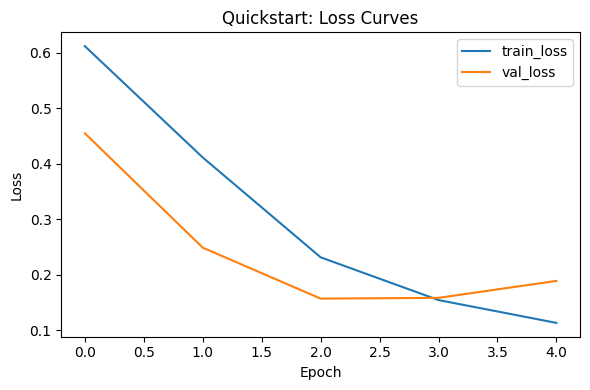

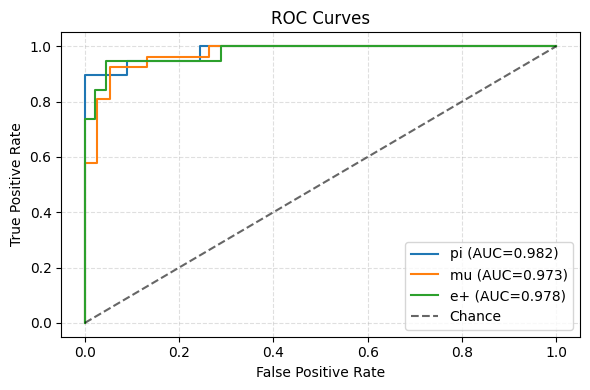

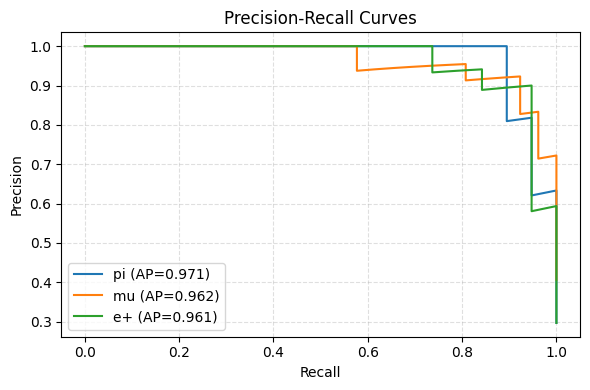

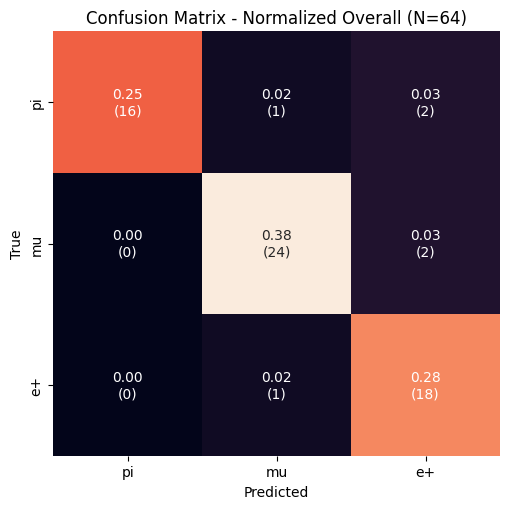

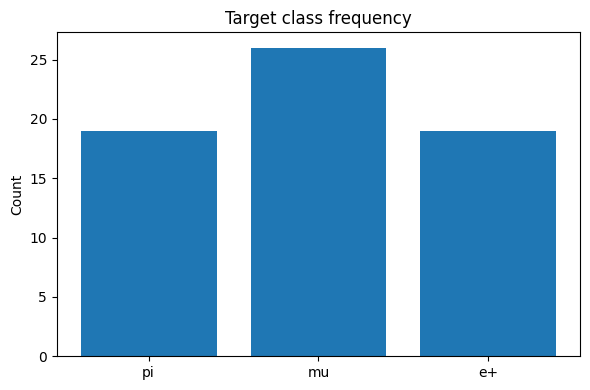

In [5]:
plot_loss_curves(
    getattr(trained_module, "train_epoch_loss_history", []),
    getattr(trained_module, "val_epoch_loss_history", []),
    title="Quickstart: Loss Curves",
    show=True,
)

plot_roc_curves(
    predictions=preds,
    targets=targets,
    class_names=["pi", "mu", "e+"],
    show=True,
)

plot_precision_recall_curves(
    predictions=preds,
    targets=targets,
    class_names=["pi", "mu", "e+"],
    show=True,
)

plot_multilabel_confusion_matrix(
    predictions=preds,
    targets=targets,
    class_names=["pi", "mu", "e+"],
    show=True,
)

PLOT_REGISTRY["class_frequency"](
    predictions=preds,
    targets=targets,
    class_names=["pi", "mu", "e+"],
    show=True,
)
